# Интерпретация А/А теста.

## Описание задания  
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

 

#### Описание колонок:  
- experimentVariant – вариант эксперимента
- version – версия приложения
- purchase – факт покупки
 

#### Задача:
- Запустите A/A-тест
- Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
- Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
- Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('lesson_10_hw_aa.csv', sep=';', index_col=0)

In [4]:
df

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


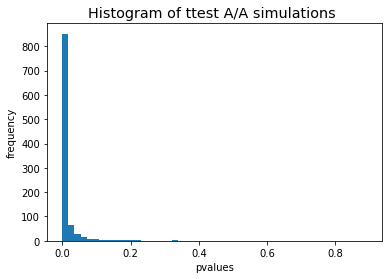

In [6]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df['experimentVariant'] == 0]['purchase'].sample(n_s, replace = False).values
    s2 = df[df['experimentVariant'] == 1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

Считаем количество случаев, непревышающих альфа.

In [7]:
sum(np.array(res) <0.05) / simulations

0.938

In [11]:
df.groupby(['experimentVariant', 'version']).agg({'uid' : 'count', 'purchase' : 'mean'})

uid  purchase
experimentVariant version                  
0                 v2.8.0    41283  0.000993
                  v2.9.0    11921  0.074658
                  v3.7.4.0   4204  0.059943
                  v3.8.0.0   5694  0.057604
1                 v2.8.0    41552  0.045606
                  v2.9.0    12033  0.071304
                  v3.7.4.0   4221  0.063018
                  v3.8.0.0   6110  0.062848

Видно, что у пользователей с v2.8.0 в разных вариантах эксперемента конверсия отличается в целых 5 раз. В добавок к этому можно заметить, что пользователи с этой версией составляют примерно 2/3 всех пользователей, учавствующих в эксперементе. Значит мы можем сделать вывод, что именно эти пользователи наиболее вероятно являются причиной разницы между эксперементами.

На всякий случай проведём t-тест для каждой версии приложения и исключим из эксперементов те версии, где p-value < 0.05

### v2.8.0

In [24]:
stats.ttest_ind(df[(df['experimentVariant'] == 0) & (df['version'] == 'v2.8.0')]['purchase'],
                df[(df['experimentVariant'] == 1) & (df['version'] == 'v2.8.0')]['purchase'])

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

### v2.9.0

In [25]:
stats.ttest_ind(df[(df['experimentVariant'] == 0) & (df['version'] == 'v2.9.0')]['purchase'],
                df[(df['experimentVariant'] == 1) & (df['version'] == 'v2.9.0')]['purchase'])

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

### v3.7.4.0

In [26]:
stats.ttest_ind(df[(df['experimentVariant'] == 0) & (df['version'] == 'v3.7.4.0')]['purchase'],
                df[(df['experimentVariant'] == 1) & (df['version'] == 'v3.7.4.0')]['purchase'])

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

### v3.8.0.0

In [27]:
stats.ttest_ind(df[(df['experimentVariant'] == 0) & (df['version'] == 'v3.8.0.0')]['purchase'],
                df[(df['experimentVariant'] == 1) & (df['version'] == 'v3.8.0.0')]['purchase'])

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

Как и ожидалось, только подвыборки с версией v2.8.0 имеют статистически значимые отличия.

Исключим эту версию, и проведём А/А тест заново.

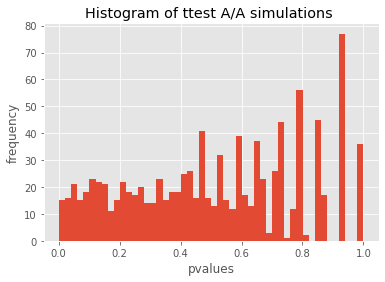

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 0) & (df['version'] != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 1) & (df['version'] != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [13]:
sum(np.array(res) <0.05) / simulations

0.037

Теперь FPR < 0.05, значит выборки одинаковые. Отлично!